In [1]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(1, '../main')
from sklearn.ensemble import RandomForestClassifier
from main import *
import CustomTransformer as ctrans
sys.path.insert(1, '../main/utils')
import altcoinUtils as utils

In [2]:
from sklearn import feature_selection
inputDataDirPath = os.path.join(current_dir_path, '../main/input_data')

period = "5min"
periodInSeconds = 5 * 60  # in seconds
numberSecondsIn1Month = 30 * 24 * 60 * 60
numberPeriodIn1Month =  int(numberSecondsIn1Month / periodInSeconds) # Testing for 1 month
numberPeriodIn2Month = 2 * numberPeriodIn1Month
if __name__ == "__main__":

    currency = "ETH"
    currencyPairToForecast = "BTC_ETH"
    currencyPairsToTrain = ["BTC_ETH", "USDT_BTC", "USDT_ETH"] # currencyPairs used by the ML algo
    startDate = '2017-02-01-23:00:00'
    endDate = '2017-07-15-23:00:00'

    dates = pd.date_range(startDate, endDate, freq=period)

    endDateTraining = '2017-05-15-23:00:00'
    datesTraining = pd.date_range(startDate, endDateTraining, freq = period)
    datesTesting = pd.date_range(endDateTraining, endDate, freq=period)

    # We need to adjust it based on the taker fees
    # percentageTreshold = 0.7 * 0.01
    percentageTresholdsList = [0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]
    percentageTresholdToTrain = 0.5
    returnPeriodList=[ 1, 2, 3, 4, 5, 6, 7, 10, 14, 25, 48, 70, 144, 180, 250, 336]
    GENERATE_DATA_FRAME = False  # set to true if you want to build a the dataset
    if GENERATE_DATA_FRAME:
        # setup_dataframe_refactored(currencyPairToForecast, currencyPairsToTrain, dates, period, percentageTreshold, postfix = "botTestRefactored")
        setup_dataframe_generalised(currencyPairToForecast, currencyPairsToTrain, dates, period, percentageTresholdsList, returnPeriodList,
                                    postfix = "botTestGeneralised")
    dataFrame = utils.load_data(period + "botTestGeneralised", inputDataDirPath)

In [3]:
    sys.path.insert(1, '../main/models')
    import random_forest as rf
    X_train, X_test, y_train, y_test = splitDataTrainTest(dataFrame, currencyPairToForecast,
                                                        datesTraining, datesTesting, period,
                                                        percentageTresholdToTrain, percentageTresholdsList)
    X_train = X_train.dropna()
    y_train = y_train.dropna()
    dataFrameRAWClose = altcoinUtils.getDataFromCSV([currencyPairToForecast], dates, period, how='inner', usecols=['Date', 'Close'], Input_path = '../main/input_data/raw/')
    classifier = rf.RandomForestClassifier(n_estimators=100, min_samples_leaf=10,
                                           min_samples_split=10,max_depth=7)
    X_train.columns.values

array(['1D BTC_ETH', '1D USDT_BTC', '1D USDT_ETH', 'Volume BTC_ETH',
       'Volume USDT_BTC', 'Volume USDT_ETH', '2D BTC_ETH', '2D USDT_BTC',
       '2D USDT_ETH', '3D BTC_ETH', '3D USDT_BTC', '3D USDT_ETH',
       '1D Avg_BTC_ETH', '1D Avg_USDT_BTC', '1D Avg_USDT_ETH',
       '2D Avg_BTC_ETH', '2D Avg_USDT_BTC', '2D Avg_USDT_ETH',
       '3D Avg_BTC_ETH', '3D Avg_USDT_BTC', '3D Avg_USDT_ETH'], dtype=object)

In [4]:
############################################
# Pipeline and GridSearchCV
############################################
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [5]:
# feature selection and classifier
pipe = Pipeline([
    ('featureSelection', SelectKBest()),
    ('classify', classifier)
])

############################################
# set up param_grid for two different feature selection algorithm
# 1. PCA
# 2. SelectKBest
############################################

numberFeatures=X_train.shape[1]
N_FEATURES_OPTIONS = [1, 6, 11]
param_grid = [
    {
        'featureSelection': [SelectKBest(mutual_info_classif)],
        'featureSelection__k': N_FEATURES_OPTIONS,
    },
]

In [6]:
grid = GridSearchCV(pipe, cv=3, n_jobs=1, param_grid=param_grid)
grid.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(steps=[('featureSelection', SelectKBest(k=10, score_func=<function f_classif at 0x1082306a8>)), ('classify', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features='auto', max_leaf_nodes=None,
            min_impurity_spli...ators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'featureSelection': [SelectKBest(k=1, score_func=<function mutual_info_classif at 0x108528378>)], 'featureSelection__k': [1, 6, 11]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

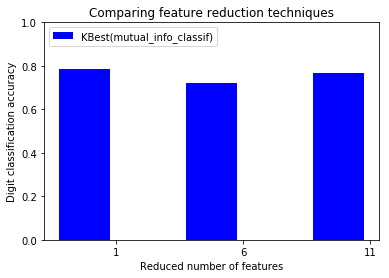

In [9]:
reducer_labels = ['KBest(mutual_info_classif)']
import matplotlib.pyplot as plt
mean_scores = np.array(grid.cv_results_['mean_test_score'])
# scores are in the order of param_grid iteration, which is alphabetical
mean_scores = mean_scores.reshape(1, -1, len(N_FEATURES_OPTIONS))
# select score for best C
mean_scores = mean_scores.max(axis=0)
bar_offsets = (np.arange(len(N_FEATURES_OPTIONS)) *
               (len(reducer_labels) + 1) + .5)

plt.figure()
COLORS = 'bgrcmyk'
for i, (label, reducer_scores) in enumerate(zip(reducer_labels, mean_scores)):
    plt.bar(bar_offsets + i, reducer_scores, label=label, color=COLORS[i])

plt.title("Comparing feature reduction techniques")
plt.xlabel('Reduced number of features')
plt.xticks(bar_offsets + len(reducer_labels) / 2, N_FEATURES_OPTIONS)
plt.ylabel('Digit classification accuracy')
plt.ylim((0, 1))
plt.legend(loc='upper left')
plt.show()